<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Crack detection/SAM custom train/SAM training')

In [4]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-9ett1g18
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-9ett1g18
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=9766908b66aad8cde113b7eed0b2d045a4c656aa84f835825daf0e50a2ead718
  Stored in directory: /tmp/pip-ephem-wheel-cache-wiica45f/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

Load data into numpy arrays. Here we are importing a tiff stack containing 165 images of size 768x1024. You can use glob to import multiple images from a directory or any other method. The goal is to end up with a numpy array for images and an array for masks.

In [26]:
mask = os.listdir('/content/drive/MyDrive/Crack detection/SAM custom train/TrainMask')
sorted_masks = sorted(mask)
images = os.listdir('/content/drive/MyDrive/Crack detection/Data/images/train')
sorted_images = sorted(images)


In [47]:
import os
large_masks=[Image.open('/content/drive/MyDrive/Crack detection/SAM custom train/TrainMask/'+mask) for mask in sorted_masks]
large_images=[Image.open('/content/drive/MyDrive/Crack detection/Data/images/train/'+image) for image in sorted_images]

In [48]:
large_images=np.asarray(large_images)
large_masks=np.asarray(large_masks)

In [53]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(image) for image in large_images],
    "label": [Image.fromarray(mask) for mask in large_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

Let us make sure out images and masks (labels) are loading appropriately

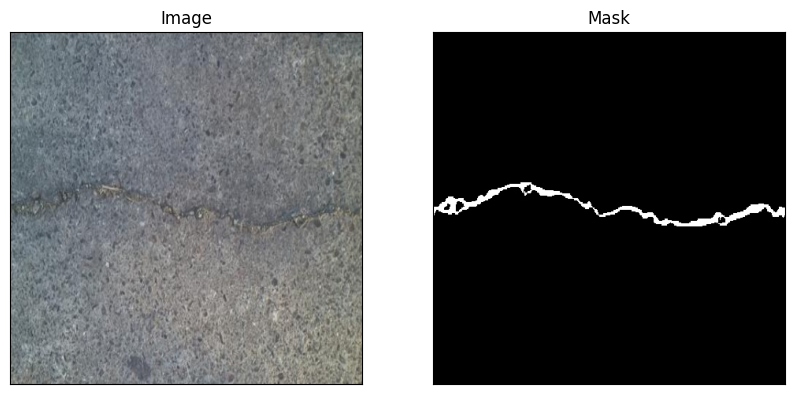

In [54]:
img_num = random.randint(0, large_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Get bounding boxes from masks. You can get here directly if you are working with coco style annotations where bounding boxes are captured in a JSON file.

In [33]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [55]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [35]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base") # there are three pretrained models base,large,huge

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [56]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [57]:
example = np.ndarray(train_dataset[0])
for k,v in example.items():
  print(k,v.shape)


TypeError: expected a sequence of integers or a single integer, got '{'pixel_values': tensor([[[-0.0629, -0.0972, -0.1999,  ...,  0.0227,  0.0056,  0.0056],
         [-0'

In [58]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [62]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 448, 448])


In [63]:
batch["ground_truth_mask"].shape

torch.Size([2, 448, 448])

In [64]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-large")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [44]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=0.05, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [78]:
from tqdm import tqdm
from statistics import mean
import torch
import torch.nn.functional as F

# Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().unsqueeze(1).to(device)

        # Resize ground truth masks to match predicted masks size
        ground_truth_masks_resized = F.interpolate(ground_truth_masks, size=predicted_masks.shape[2:], mode='bilinear', align_corners=False)

        # Calculate the loss
        loss = seg_loss(predicted_masks, ground_truth_masks_resized)

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


100%|██████████| 215/215 [07:49<00:00,  2.18s/it]

EPOCH: 0
Mean loss: -8.983580662483392


In [76]:
# from tqdm import tqdm
# from statistics import mean
# import torch
# from torch.nn.functional import threshold, normalize

# #Training loop
# num_epochs = 50

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

# model.train()
# for epoch in range(num_epochs):
#     epoch_losses = []
#     for batch in tqdm(train_dataloader):
#       # forward pass
#       outputs = model(pixel_values=batch["pixel_values"].to(device),
#                       input_boxes=batch["input_boxes"].to(device),
#                       multimask_output=False)

#       # compute loss
#       predicted_masks = outputs.pred_masks.squeeze(1)
#       ground_truth_masks = batch["ground_truth_mask"].float().to(device)
#       loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

#       # backward pass (compute gradients of parameters w.r.t. loss)
#       optimizer.zero_grad()
#       loss.backward()

#       # optimize
#       optimizer.step()
#       epoch_losses.append(loss.item())

#     print(f'EPOCH: {epoch}')
#     print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/215 [00:02<?, ?it/s]


AssertionError: ground truth has different shape (torch.Size([2, 1, 448, 448])) from input (torch.Size([2, 1, 256, 256]))

In [79]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "mito_model_checkpoint.pth")

**Inference**

In [80]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [81]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("mito_model_checkpoint.pth"))

<All keys matched successfully>

In [82]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-23): 24 x SamVisionLayer(
        (layer_norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (layer_norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=1024, out_features=4096, bias=True)
          (lin2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNor

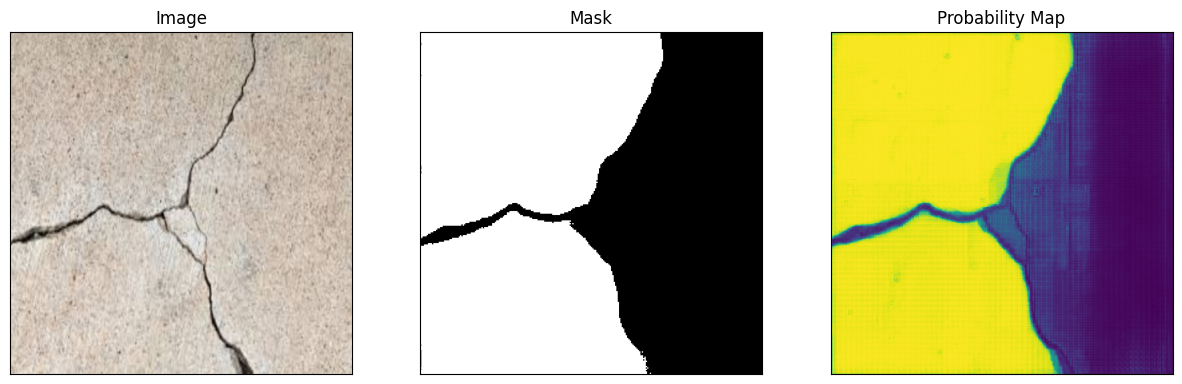

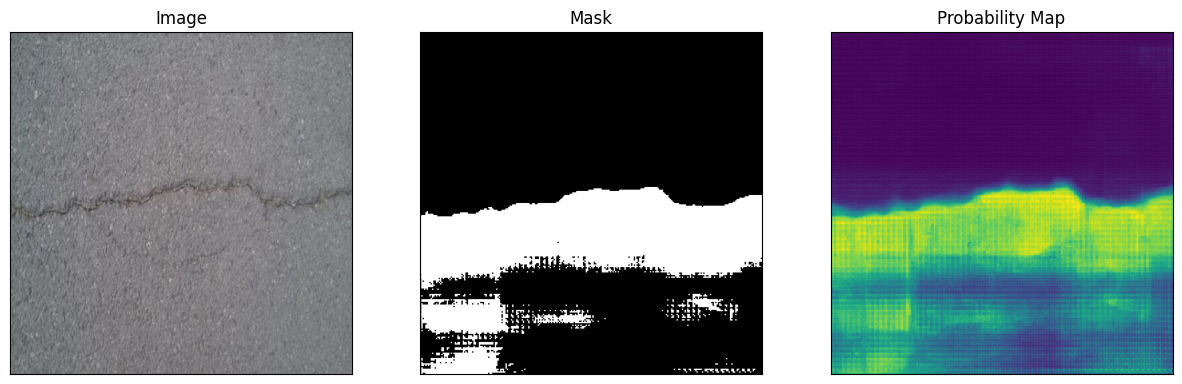

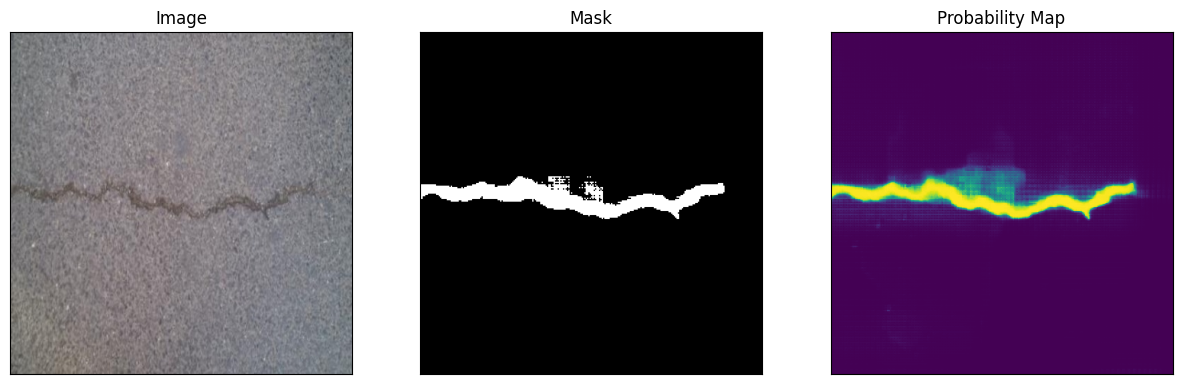

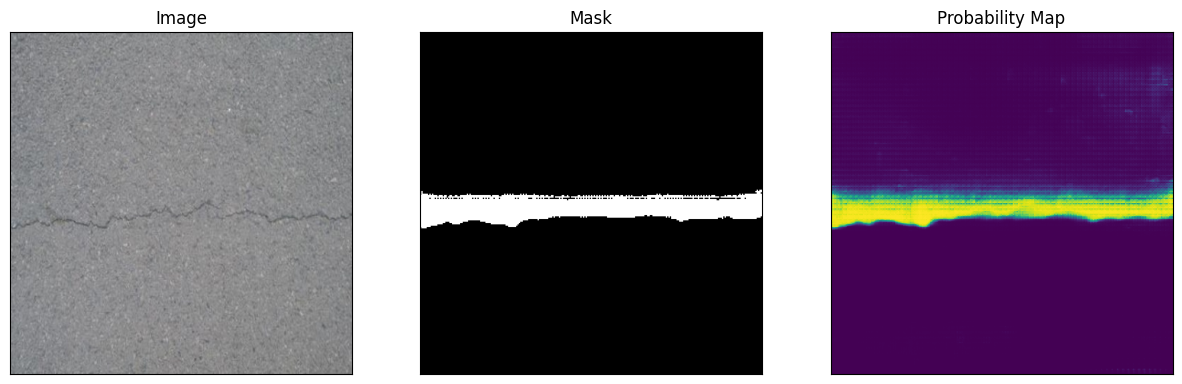

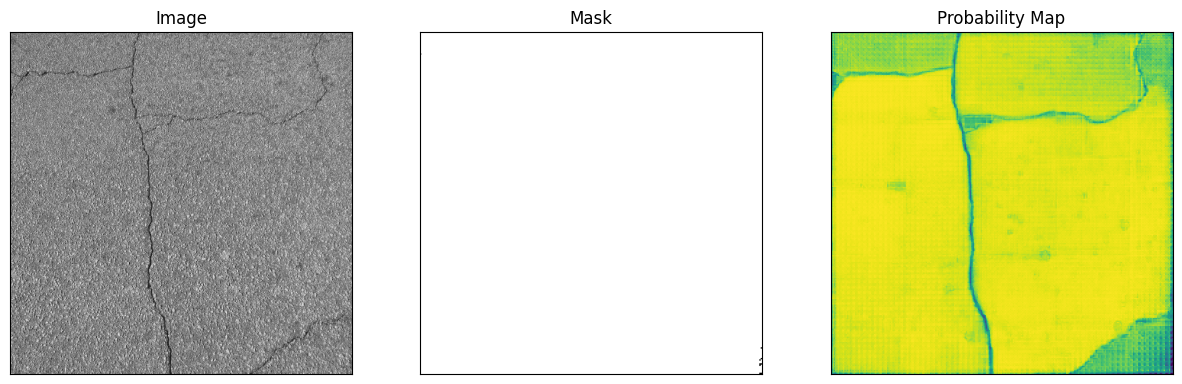

In [84]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
for i in range(5):
    idx = random.randint(0, large_images.shape[0]-1)

    # load image
    test_image = dataset[idx]["image"]

    # get box prompt based on ground truth segmentation map
    ground_truth_mask = np.array(dataset[idx]["label"])
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image + box prompt for the model
    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(device) for k, v in inputs.items()}

    my_mito_model.eval()

    # forward pass
    with torch.no_grad():
        outputs = my_mito_model(**inputs, multimask_output=False)

    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first image on the left
    axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
    axes[0].set_title("Image")

    # Plot the second image on the right
    axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
    axes[1].set_title("Mask")

    # Plot the second image on the right
    axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
    axes[2].set_title("Probability Map")

    # Hide axis ticks and labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Display the images side by side
    plt.show()

In [95]:
"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.
"""
# Define the size of your array
array_size = 448

# Define the size of your grid
grid_size = 50

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

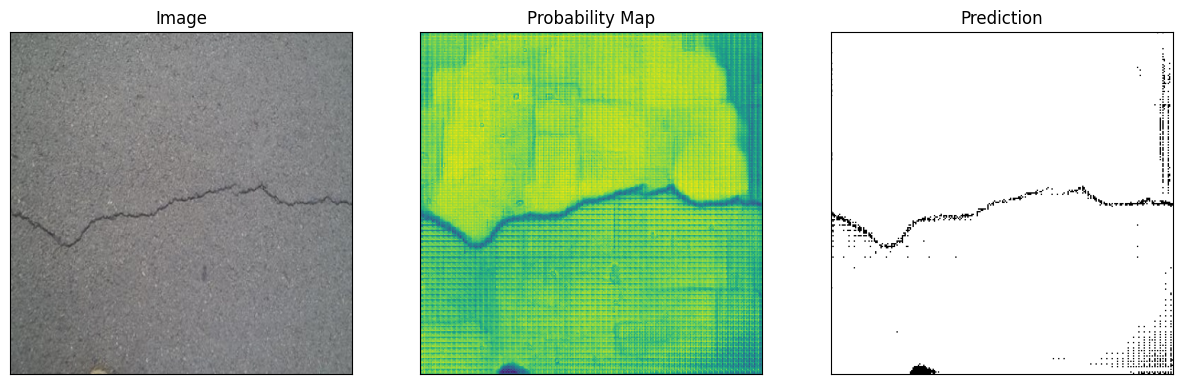

In [96]:
# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.


# Selectelected patch for segmentation
random_array = np.asarray(Image.open('/content/drive/MyDrive/Crack detection/Data/images/train/CFD_001.jpg'))


single_patch = Image.fromarray(random_array)
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()


# forward pass
with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()